# Accessing HTAN scRNA-seq with BQ and building Scanpy AnnData objects

```
Title:   Accessing HTAN scRNA-seq with BQ and building Scanpy AnnData objects.
Author:  David L Gibbs (david.gibbs@systemsbiology.org)
Created: 2022-3-29
Purpose: Building AnnData objects
URL:     
Notes:   
```

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/isb-cgc/Community-Notebooks/blob/master/HTAN/Python%20Notebooks/Building_AnnData_with_Subset_of_Cells_from_BQ.ipynb)

# 1. Introduction & Overview
[HTAN](https://humantumoratlas.org/) is a National Cancer Institute (NCI)-funded Cancer MoonshotSM initiative to construct 3-dimensional atlases of the dynamic cellular, morphological, and molecular features of human cancers as they evolve from precancerous lesions to advanced disease ( [Cell April 2020](https://www.sciencedirect.com/science/article/pii/S0092867420303469) )

This notebook shows how cells of a particular type can be pulled from BigQuery tables and used to construct an [AnnData](https://anndata.readthedocs.io/en/latest/#:~:text=anndata%20is%20a%20Python%20package,operations%2C%20and%20a%20PyTorch%20interface.) object.

### 1.1 Goal

The goal of this notebook is to show users how public HTAN single cell data can be queried and assembled for further processing.

### 1.2 Inputs, Outputs, & Data

Inputs for this analysis include HTAN single cell RNA sequencing data (Level 4, gene summarized).

Details regarding the data used:


Data was derived in April 2023 from an H5AD file (Synapse ID: syn51297089) submitted by the MSK HTAN Center. This data set contains both raw gene expression counts and log2(X+1) transformed, median-normalized expression from 62 pooled samples (N=147,137 cells). Data was generated using the 10X Genomics and was processed using SEQC, where reads were mapped to HG38, followed by cell filtering for mitochondrial fraction > 20%, empty droplet filtering (scCB2), and doublet removal (doubletdetection). Genes that were expressed in more than 10 cells were retained. Batch correction with fastMNN was performed for subsequent analysis, including UMAP visualization with scanpy and Phenograph clustering. More information available at: https://linkinghub.elsevier.com/retrieve/pii/S1535610821004979


# 2. Environment & Module Setup

Before getting started, keep in mind that there are some differences in running this notebook depending on if you are using Google Colab or running locally. We've included notes such as the following to skip or run specific lines of code depending on your setup.

In [ ]:
# If using google colab include the following install; otherwise skip if you have scanpy installed:
!pip install scanpy

In [ ]:
# GCP Libraries
from google.cloud import bigquery
from google.colab import auth

# Data Analytics
import numpy as np
from scipy import stats
from scipy import sparse
import scanpy as sc

# 3. Google Authentication

Running the BigQuery cells in this notebook requires a Google Cloud Project, instructions for creating a project can be found in the [Google Documentation](https://cloud.google.com/resource-manager/docs/creating-managing-projects#console). The instance needs to be authorized to bill the project for queries. For more information on getting started in the cloud see [Quick Start Guide to ISB-CGC](https://nbviewer.org/github/isb-cgc/Community-Notebooks/blob/master/Notebooks/Quick_Start_Guide_to_ISB_CGC.ipynb) and alternative authentication methods can be found in the [Google Documentation](https://cloud.google.com/resource-manager/docs/creating-managing-projects#console).

In [ ]:
# if you're using Google Colab, authenticate to gcloud with the following:
auth.authenticate_user()
#Otherwise, ignore the section above.

# alternatively, to use the gcloud SDK, please use:
#!gcloud auth application-default login

In [ ]:
## Setup ##

# set the google project that will be billed for this notebook's computations
google_project = 'my-project'

# Create a client to access the data within BigQuery
client = bigquery.Client(google_project)

In this notebook, we select a subset of cells from BigQuery,
and then construct an AnnData object, which lets us continue
working with the Scanpy library.

# 4. Building AnnDatas from BigQuery

If the data is transfered to big query in a way that preserves the AnnData structures, with X, obs, and var tables, then it should be easy to reconstruct the data structure and use Scanpy functions.

An AnnData requires three parts, the gene counts X, the gene index var, and the cell barcodes obs.

In [ ]:
# first to get the matrix of gene counts
# here we will use the MSK scRNAseq table from HTAN in isb-cgc-bq

X = client.query("""

  SELECT
    iObs,
    iVar,
    X_value
  FROM
  `isb-cgc-bq.HTAN.scRNAseq_MSK_SCLC_combined_samples_current`
  WHERE
    iObs in (
    SELECT
      distinct(iObs) from
  `isb-cgc-bq.HTAN.scRNAseq_MSK_SCLC_combined_samples_current`
      WHERE
      Cell_Type = 'B cell' AND
      sex = 'female'
          )

    """).result().to_dataframe()

In [ ]:
X

,iObs,iVar,X_value
0,131092,10316,1.129003
1,131345,10316,1.187704
2,131564,10316,1.226468
3,131764,10316,2.093081
4,131785,10316,2.324389
...,...,...,...
2540556,147130,11249,1.599192
2540557,147130,11253,0.420390
2540558,147130,11275,0.745520
2540559,147130,11276,1.751903


In [ ]:
# now we're going to get the observations for each cell

obs = client.query("""

SELECT
  iObs,
  cell_type,
  donor_id,
  clusters,
  treatment,
  self_reported_ethnicity,
  histo,
  development_stage
FROM
  `isb-cgc-bq.HTAN.scRNAseq_MSK_SCLC_combined_samples_current`
WHERE
      Cell_Type = 'B cell' AND
      sex = 'female'
GROUP BY
  1,2,3,4,5,6,7,8

    """).result().to_dataframe()

In [ ]:
obs

,iObs,cell_type,donor_id,clusters,treatment,self_reported_ethnicity,histo,development_stage
0,16998,B cell,RU1038,4,Naive,European,LUAD,84-year-old human stage
1,81780,B cell,RU1038,4,Naive,European,LUAD,84-year-old human stage
2,7489,B cell,RU1038,4,Naive,European,LUAD,84-year-old human stage
3,85058,B cell,RU1038,4,Naive,European,LUAD,84-year-old human stage
4,121116,B cell,RU1057,4,Naive,European,LUAD,67-year-old human stage
...,...,...,...,...,...,...,...,...
2393,45182,B cell,RU1144,4,Platinum Doublet,European,SCLC,64-year-old human stage
2394,58975,B cell,RU1144,4,Platinum Doublet,European,SCLC,64-year-old human stage
2395,138929,B cell,RU1311,4,Platinum Doublet,European,SCLC,77-year-old human stage
2396,96470,B cell,RU1038,4,Naive,European,LUAD,84-year-old human stage


In [ ]:
# first to get the matrix of gene counts

var = client.query("""

  SELECT
    iVar,
    feature_name as GeneSymbol
  FROM
  `isb-cgc-bq.HTAN.scRNAseq_MSK_SCLC_combined_samples_current`
  WHERE
      Cell_Type = 'B cell' AND
      sex = 'female'
  GROUP BY 1,2
    """).result().to_dataframe()



In [ ]:
var

,iVar,GeneSymbol
0,6723,GARS1
1,15745,RP11-396B14.2
2,16299,RP11-557N21.1
3,1789,ATP1A2
4,2385,CADM3
...,...,...
16213,5401,EIF2A
16214,1710,ASPHD2
16215,1726,ATAD1
16216,7127,GPM6B


We need to do a little bit of table index shifting.

In [ ]:
# fix the obs index by reindexing
# this maps the X table to the obs table
iObsDict = dict(zip(obs.iObs, obs.index))
X.iObs = [iObsDict[a] for a in X.iObs]

In [ ]:
# the var index also needed a fix by reindexing
# this maps the X table to the var table
iVarDict = dict(zip(var.iVar, var.index))
X.iVar = [iVarDict[a] for a in X.iVar]
# and scanpy indexes things by gene symbol
var.index = var.GeneSymbol

In [ ]:
# now with indices that map to the obs and var tables.
X

,iObs,iVar,X_value
0,475,10588,1.129003
1,2021,10588,1.187704
2,841,10588,1.226468
3,1782,10588,2.093081
4,1264,10588,2.324389
...,...,...,...
2540556,916,11884,1.599192
2540557,916,2383,0.420390
2540558,916,1176,0.745520
2540559,916,2985,1.751903


In [ ]:
# convert the pandas table to a sparse matrix
sparseX2 = sparse.csr_matrix( (X.X_value, (X.iObs, X.iVar)) )  #, shape=(max(X.iObs), max(X.iVar))
sparseX2

<2398x16218 sparse matrix of type '<class 'numpy.float64'>'
	with 2540561 stored elements in Compressed Sparse Row format>

In [ ]:
# now we can build the AnnData
adata = sc.AnnData(X=sparseX2, obs=obs, var=var)
adata.var_names_make_unique()

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
adata

AnnData object with n_obs × n_vars = 2398 × 16218
    obs: 'iObs', 'cell_type', 'donor_id', 'clusters', 'treatment', 'self_reported_ethnicity', 'histo', 'development_stage'
    var: 'iVar', 'GeneSymbol'

In [ ]:
# select some genes by expression level
geneCountsSum = (np.array(adata.X.sum(axis=0))[0,:])
highExprGenes = adata.var.iloc[ np.where(geneCountsSum > 7000) ].index

In [ ]:
highExprGenes

Index(['ACTB', 'HLA-DRA', 'EIF1', 'FTL', 'B2M', 'HSP90AB1', 'RACK1', 'HLA-B',
       'NACA', 'CD74', 'FTH1', 'HLA-C', 'EEF1B2', 'HLA-DPA1', 'H3-3B', 'TPT1',
       'PTMA', 'BTG1', 'HLA-DPB1', 'HLA-A', 'HSP90AA1', 'EEF1A1', 'CXCR4'],
      dtype='object', name='GeneSymbol')

         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


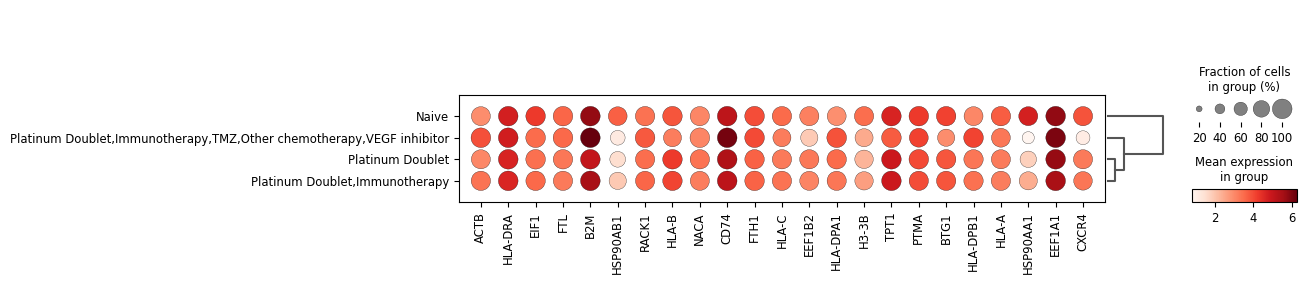

In [ ]:
# now we can use the plot functions of scanpy
sc.pl.dotplot(adata, highExprGenes, 'treatment', dendrogram=True)

In [ ]:
adata.obs.treatment.value_counts()

Naive                                                                   1784
Platinum Doublet                                                         453
Platinum Doublet,Immunotherapy                                           142
Platinum Doublet,Immunotherapy,TMZ,Other chemotherapy,VEGF inhibitor      19
Name: treatment, dtype: int64

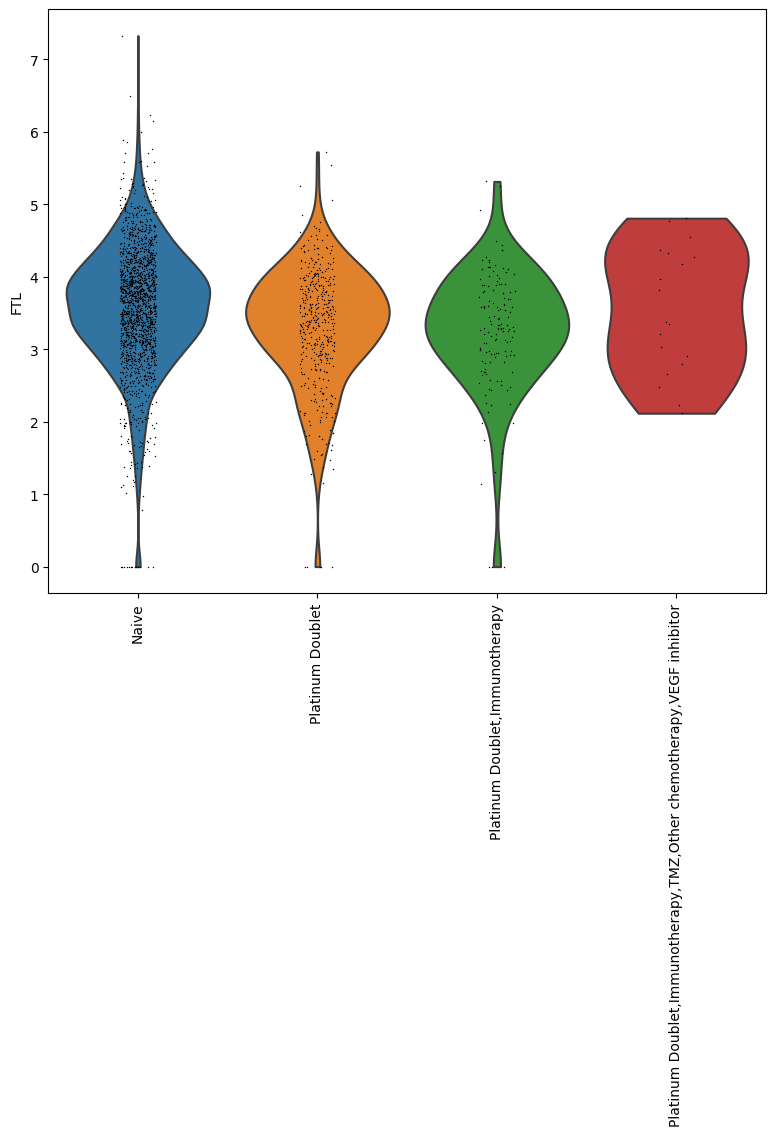

In [ ]:
sc.pl.violin(adata, ['FTL'], groupby='treatment', rotation=90)

In [ ]:
# We have pulled a subset of cells outof BQ and constructed an AnnData object.

# 5. Relevant Citations and Links


[HTAN Portal](https://humantumoratlas.org/)   


[Overview paper, Cell, April 2020](https://www.sciencedirect.com/science/article/pii/S0092867420303469)

[Data Used](https://linkinghub.elsevier.com/retrieve/pii/S1535610821004979)
